# Random Forest Classifier

In [1]:
import os
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
import pandas as pd
import numpy as np
#from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, roc_auc_score#, classification_report, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)

#### Import data

In [2]:
standardize = False
if standardize:
        csv='data/df_20161022_onehot_std.csv'
else:
    #csv='data/df_20161022_onehot.csv', data/df_20161022_1.csv', 'data/df.csv'
    csv='data/df_20161022_onehot.csv'
df = pd.read_csv(csv)
df.head()

,is_auto_renew,is_cancel,reg_to_trans_days,is_churn,registration_winter,registration_spring,registration_summer,registration_autumn,registration_beginOfMonth,registration_middleOfMonth,...,transaction_DayofMonth_29,transaction_DayofMonth_30,transaction_DayofMonth_31,transaction_DayOfWeek_0,transaction_DayOfWeek_1,transaction_DayOfWeek_2,transaction_DayOfWeek_3,transaction_DayOfWeek_4,transaction_DayOfWeek_5,transaction_DayOfWeek_6
0,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,4098,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,4021,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,1,0,4021,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [3]:
X = df.drop('is_churn', axis=1) # drop unknown churn
y = df[['is_churn']]
y = np.ravel(y)
print(y[:5])
print("Predictor variables:",X.shape[1])
print("Samples:",y.shape[0])

[0 0 0 1 0]
Predictor variables: 371
Samples: 17124


#### Standardization of continuous variables
Standardization: This technique transforms the data to have a mean of zero and a standard deviation to 1.
Standardization is performed after cutting off on some date, since in reality there will be no access to future data. We will see how to select the strategies based on Gaussian and Non-Gaussian distribution of the features to improve the performance of the Logistic Regression model.
https://towardsdatascience.com/feature-scaling-effectively-choose-input-variables-based-on-distributions-3032207c921f

In [4]:
from sklearn.preprocessing import StandardScaler
standardize = False # also check if input was already standardized
if standardize:
    cols2standardize = ['reg_to_trans_days','num_25_av7','num_50_av7','num_75_av7','num_985_av7','num_100_av7',
                'num_25_av30','num_50_av30','num_75_av30','num_985_av30','num_100_av30',
                'num_25_av90','num_50_av90','num_75_av90','num_985_av90','num_100_av90',
                'num_unq_av7','num_unq_av30','num_unq_av90','total_secs_av7','total_secs_av30','total_secs_av90']
    print(f"Continuous variables to standardize: {len(cols2standardize)}")
    display(X[cols2standardize].head(1))
    scaler = StandardScaler()
    X_std = pd.DataFrame(scaler.fit_transform(X[cols2standardize]), columns=cols2standardize) # standardized continuous variables
    X_nostd = X.drop(cols2standardize, axis=1) # all other variables
    X = pd.concat([X_nostd,pd.DataFrame(X_std)], axis=1) # concatenate columns
    print("with_mean =",scaler.mean_) # =np.mean(X[cols2standardize]); to be re-used in predictions
    print("with_std =",scaler.scale_)
    print("X is standardized (mean = 0, sd = 1), X.shape =",X.shape)
    pd.concat([pd.DataFrame(X),pd.DataFrame(y, columns=['is_churn'])],axis=1).to_csv("data/df_20161022_onehot_std.csv", index=False)
else: print("X is not scaled, but check if input was already standardized")

X is not scaled, but check if input was already standardized


#### Performance metrics

In [5]:
def scores_all(X_test, y_test, model):
    '''Quality Metrics: roc_auc, accuracy, tnr, tpr, precision, f1, MCC'''
    y_score = model.predict_proba(X_test)[:,1] # predicted probabilities of y=1
    y_pred = model.predict(X_test) # predicted labels 0,1
    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    
    roc_auc = roc_auc_score(y_test, y_score)
    #print(f"roc_auc_score = {round(roc_auc,dr)}: Area under ROC curve.")

    y_predicted = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predicted)
    #print(f"Accuracy = {round(accuracy,dr)}: (TN+TP)/(TN+TP+FN+FP): Accuracy: percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    
    tnr = tn/(tn + fp) # tnr = 1-fpr
    #print(f"TNR = {round(tnr,dr)}: Specificity, selectivity or true negative rate (TNR), proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp) # fpr = 1-tnr
    #print(f"FPR = {round(fpr,de)} Fall-out or false positive rate (FPR), or Type I Error: proportion of the negative class 0 got incorrectly classified.")

    fnr = fn/(fn + tp) # fnr = 1-tpr
    #print(f"FNR = {round(fnr,dr)}: Type II Error, miss rate or false negative rate (FNR): Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn) # tpr = 1-fnr
    #print(f"TPR = {round(tpr,dr)}: TP/(TP+FN): Sensitivity, recall, hit rate, or true positive rate (TPR): proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    
    precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
    #print(f"Precision = {round(precision,dr)}: TP/PP = TP/(TP+FP)")
    #print(f"Precision = {round(precision_score(y_actual, y_predicted),dr)}")
    
    f1 = 2*tp/(2*tp+fp+fn)
    #print(f"F1 score = {round(f1,dr)}: F1 score: harmonic mean of precision and recall.")
    #print(f"F1 score = {round(f1_score(y_actual, y_predicted),dr)}: F1 score: harmonic mean of precision and recall.")
    
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #print(f"MCC = {round(MCC,dr)}: Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")
    
    #print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
    #print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
    return roc_auc, accuracy, tnr, tpr, precision, f1, MCC;

#### No split

In [13]:
# Train using entire dataset, default hyperparameters
rf_ns = RandomForestClassifier(random_state=0).fit(X, y)
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X, y, rf_ns)
print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
print( confusion_matrix(y, rf_ns.predict(X)) )

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.99996	0.99831	0.99968	0.98227	0.99625	0.98922	0.98833
[[15765     5]
 [   24  1330]]


In [85]:
?rf_ns # see defaults

#### Sweeping hyperparameters, no split

In [7]:
print(standardize, csv)

False data/df_20161022_onehot.csv


In [ ]:
# Initialize score dataframe
if standardize:
    scores_csv = 'data/RandomForest.std_ns.hyperparam_sweep_scores.csv'
else:
    scores_csv = 'data/RandomForest.ns.hyperparam_sweep_scores.csv'
if os.path.exists(scores_csv):
    scores = pd.read_csv(scores_csv)
else:
    scores = pd.DataFrame(columns=['criterion','max_features','max_depth','n_estimators', 'roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])
display(scores.head())
display(scores.tail())

# Grid sweeping of hyperparameters using GridSearchCV
for criterion in ['entropy']: #['gini', 'entropy']
  for max_features in ['auto', 'sqrt', 'log2', 0.5]:
    for max_depth in np.arange(1,50+1,1):
      for n_estimators in np.arange(1,10+1,1):
        # Create and train the Logistic Regression model
        rf_nosplit = RandomForestClassifier(criterion=criterion, max_features=max_features,
            max_depth=max_depth, n_estimators=n_estimators,  random_state=0).fit(X,y)
        roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X, y, rf_nosplit);
        scores = scores.append({'criterion':criterion,'max_features':max_features,'max_depth':max_depth,'n_estimators':n_estimators,
            'roc_auc':roc_auc,'accuracy':accuracy,'tnr':tnr,'tpr':tpr,'precision':precision,'f1':f1,'mcc':mcc}, ignore_index=True)
      scores.to_csv(scores_csv)
scores.sort_values(['criterion','max_features','max_depth','n_estimators'], inplace=True)
scores.to_csv(scores_csv, index=False)

auc_max = np.max(scores['roc_auc'])
print("Currently maximal ROC AUC:",auc_max)
print("Currently optimal hyperparameters:")
print( scores.loc[scores['roc_auc']==auc_max] )

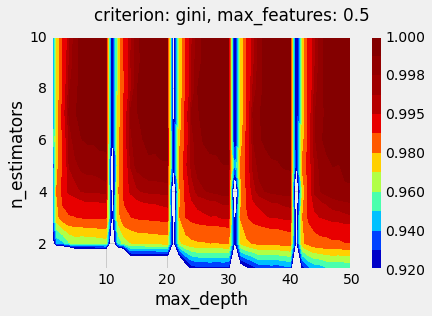

In [14]:
# Contour plot for a chosen combination of (criterion, max_features)
criterion = 'gini'
max_features='0.5'
ds = scores.loc[(scores['criterion']==criterion) & (scores['max_features']==max_features)] # dataset selection
x_val = ds['max_depth'].unique()
y_val = ds['n_estimators'].unique()

#https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
plt.contourf(x_val, y_val, np.array(ds['roc_auc']).reshape(len(y_val), len(x_val)),
             levels=np.concatenate( (np.arange(0.92,0.991,0.01), np.array([0.995, 0.997, 0.998, 0.999, 1])) ), cmap='jet'); #https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.colorbar();
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.suptitle(f'criterion: {criterion}, max_features: {max_features}');

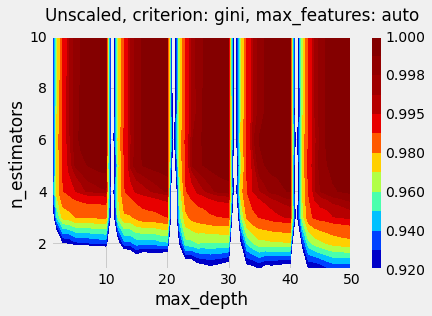

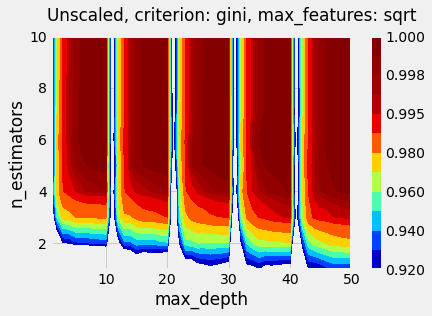

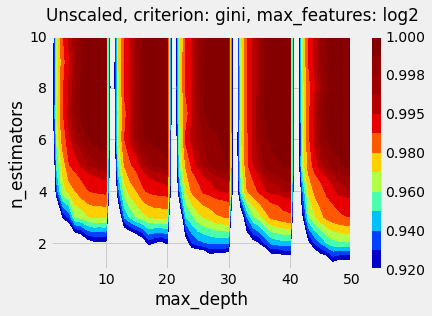

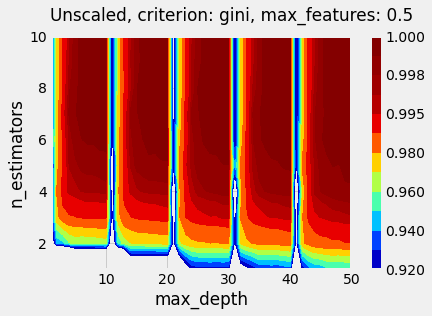

In [15]:
criterion = 'gini'
for max_features in ['auto', 'sqrt', 'log2', '0.5']:
  ds = scores.loc[(scores['criterion']==criterion) & (scores['max_features']==max_features)] # dataset selection
  x_val = ds['max_depth'].unique()
  y_val = ds['n_estimators'].unique()
  #https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
  plt.contourf(x_val, y_val, np.array(ds['roc_auc']).reshape(len(y_val), len(x_val)),
    levels=np.concatenate( (np.arange(0.92,0.991,0.01), np.array([0.995, 0.997, 0.998, 0.999, 1])) ), cmap='jet'); #https://matplotlib.org/stable/tutorials/colors/colormaps.html
  plt.colorbar();
  plt.xlabel('max_depth')
  plt.ylabel('n_estimators')
  plt.suptitle(f'Unscaled, criterion: {criterion}, max_features: {max_features}');#Unscaled, Standardized
  plt.show()

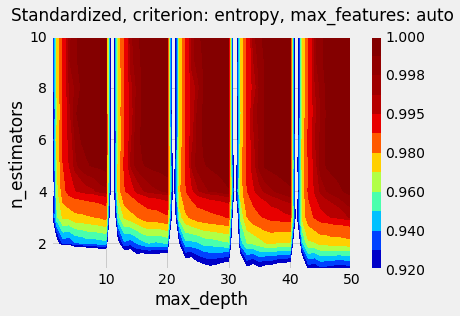

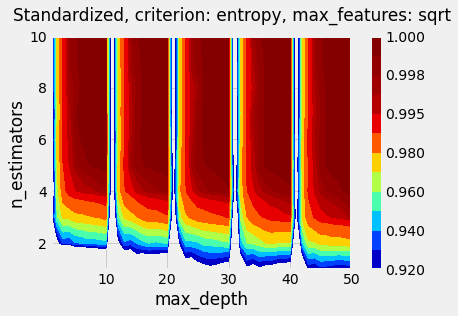

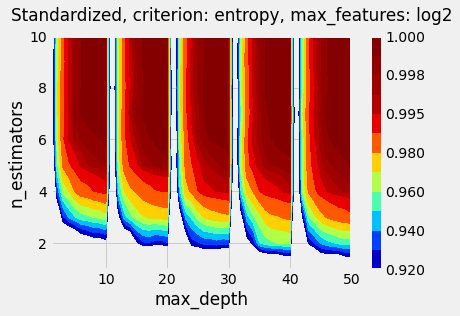

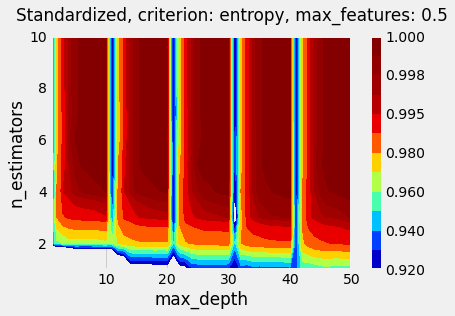

In [16]:
criterion = 'entropy'
for max_features in ['auto', 'sqrt', 'log2', '0.5']:
  ds = scores.loc[(scores['criterion']==criterion) & (scores['max_features']==max_features)] # dataset selection
  x_val = ds['max_depth'].unique()
  y_val = ds['n_estimators'].unique()
  #https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
  plt.contourf(x_val, y_val, np.array(ds['roc_auc']).reshape(len(y_val), len(x_val)),
    levels=np.concatenate( (np.arange(0.92,0.991,0.01), np.array([0.995, 0.997, 0.998, 0.999, 1])) ), cmap='jet'); #https://matplotlib.org/stable/tutorials/colors/colormaps.html
  plt.colorbar();
  plt.xlabel('max_depth')
  plt.ylabel('n_estimators')
  plt.suptitle(f'Standardized, criterion: {criterion}, max_features: {max_features}');
  plt.show()

In [ ]:
ds = scores.loc[(scores['criterion']==criterion) & (scores['max_features']==max_features)] #

In [17]:
print("Optimal parameters, standardized, no split:")
idx_opt = np.argmax(scores['roc_auc'])
scores.iloc[idx_opt]

Optimal parameters, standardized, no split:


criterion           gini
max_features        log2
max_depth             38
n_estimators          10
roc_auc         0.999791
accuracy           0.992
tnr             0.999493
tpr             0.904727
precision       0.993512
f1              0.947043
mcc             0.943935
Name: 3379, dtype: object

In [18]:
print("Optimal parameters, standardized, no split, criterion: entropy:")
idx_opt = np.argmax(scores.loc[scores['criterion']=="entropy"]['roc_auc'])
scores.iloc[idx_opt]

Optimal parameters, standardized, no split, criterion: entropy:


criterion        entropy
max_features        log2
max_depth             38
n_estimators          10
roc_auc         0.999757
accuracy        0.992525
tnr             0.999493
tpr             0.911374
precision       0.993559
f1              0.950693
mcc              0.94769
Name: 1379, dtype: object

In [19]:
print("Verification: No split, CV, Optimized ROC AUC")
rf_cv = RandomForestClassifier(criterion='gini', max_depth=38, max_features='log2', n_estimators=10, random_state=0)
scores_cv = cross_val_score(rf_cv, X, y, cv=10)
print('Cross-Validation Accuracy Scores', scores_cv)
scores_cv.min(), scores_cv.mean(), scores_cv.max()

Verification: No split, CV, Optimized ROC AUC
Cross-Validation Accuracy Scores [0.9270286  0.92936369 0.92994746 0.92060712 0.9228972  0.92406542
 0.91471963 0.92932243 0.95735981 0.94042056]


(0.9147196261682243, 0.9295731923553255, 0.9573598130841121)

#### Train-Test split
Taking 70% for training set and 30% for test set.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

Train samples: 11986
Test samples: 5138


In [15]:
print("Training on the train set, applying to the test set")
rf_s30 = RandomForestClassifier(random_state=0).fit(X_train, y_train)
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X_test, y_test, rf_s30)
print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
print( confusion_matrix(y_test, rf_s30.predict(X_test)) )

Training on the train set, applying to the test set
AUC	Accur	TNR	TPR	Precis	F1	MCC
0.95051	0.94550	0.99429	0.37990	0.85165	0.52542	0.54734
[[4703   27]
 [ 253  155]]


#### Trial run with Cross-Validation
A more reliable way of validating the model and optimizing its parameters is by cross-validation.

In [17]:
print("Example of cross-validation:")
rf_cv = RandomForestClassifier(random_state=0)
scores = cross_val_score(rf_cv, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)
scores.min(), scores.mean(), scores.max()

Example of cross-validation:
Cross-Validation Accuracy Scores [0.95079233 0.94745621 0.94495413 0.94662219 0.94245204 0.94578816
 0.95325543 0.9457429  0.95158598 0.94073456]


(0.9407345575959933, 0.9469383918986468, 0.9532554257095158)

In [52]:
print("Cross-validation of optimal train-test hyperparameters: Unscaled, No split, CV=10")
rf_cv = RandomForestClassifier(criterion='entropy', max_depth=29, max_features='auto', n_estimators=10, random_state=0)
scores_cv = cross_val_score(rf_cv, X, y, cv=10,scoring='roc_auc')
print('Cross-Validation Accuracy Scores', scores_cv)
scores_cv.min(), scores_cv.mean(), scores_cv.max()

Cross-validation of optimal train-test hyperparameters: Unscaled, No split, CV=10
Cross-Validation Accuracy Scores [0.88418069 0.89092516 0.87159163 0.89020478 0.80782545 0.83448179
 0.77289979 0.89641607 0.95752836 0.96718805]


(0.7728997862796214, 0.8773241763061879, 0.9671880504474035)

In [ ]:
# Initialize score dataframe
scores_csv = 'data/RandomForest.ns.hyperparam_sweep_scores_cv.csv'
#scores_csv = 'data/RandomForest.std_ns.hyperparam_sweep_scores_cv.csv'
if os.path.exists(scores_csv):
    scores = pd.read_csv(scores_csv)
else:
    scores = pd.DataFrame(columns=['criterion','max_features','max_depth','n_estimators', 'roc_auc_min','roc_auc_ave','roc_auc_max',
        'roc_auc_1','roc_auc_2','roc_auc_3','roc_auc_4','roc_auc_5','roc_auc_6','roc_auc_7','roc_auc_8','roc_auc_9','roc_auc_10'])
display(scores.head())
display(scores.tail())

# Grid sweeping of hyperparameters using GridSearchCV
for criterion in ['gini', 'entropy']:
  for max_features in ['auto', 'sqrt', 'log2', 0.5]:
    for max_depth in np.arange(1,50+1,1):
      for n_estimators in np.arange(1,10+1,1):
        # Create and train the Logistic Regression model
        rf = RandomForestClassifier(criterion=criterion, max_features=max_features,
            max_depth=max_depth, n_estimators=n_estimators,  random_state=0)

        
        scores_cv = cross_val_score(rf_cv, X, y, cv=10,scoring='roc_auc')
        #Cross-Validation Accuracy Scores     
        scores = scores.append({'criterion':criterion,'max_features':max_features,'max_depth':max_depth,'n_estimators':n_estimators,
            'roc_auc_min':scores_cv.min(),'roc_auc_ave':scores_cv.mean(),'roc_auc_max':scores_cv.max(),
            'roc_auc_1':scores_cv[0],'roc_auc_2':scores_cv[1],'roc_auc_3':scores_cv[2],'roc_auc_4':scores_cv[3],
            'roc_auc_5':scores_cv[4],'roc_auc_6':scores_cv[5],'roc_auc_7':scores_cv[6],'roc_auc_8':scores_cv[7],
            'roc_auc_9':scores_cv[8],'roc_auc_10':scores_cv[9]}, ignore_index=True)
      scores.to_csv(scores_csv, index=False)
scores.sort_values(['criterion','max_features','max_depth','n_estimators'], inplace=True)
scores.to_csv(scores_csv, index=False)

roc_auc_ave_max = np.max(scores['roc_auc_ave'])
print("Currently maximal roc_auc_ave:",roc_auc_ave_max)
print("Currently optimal hyperparameters:")
print( scores.loc[scores['roc_auc_ave']==roc_auc_ave_max] )

,criterion,max_features,max_depth,n_estimators,roc_auc_min,roc_auc_ave,roc_auc_max,roc_auc_1,roc_auc_2,roc_auc_3,roc_auc_4,roc_auc_5,roc_auc_6,roc_auc_7,roc_auc_8,roc_auc_9,roc_auc_10


,criterion,max_features,max_depth,n_estimators,roc_auc_min,roc_auc_ave,roc_auc_max,roc_auc_1,roc_auc_2,roc_auc_3,roc_auc_4,roc_auc_5,roc_auc_6,roc_auc_7,roc_auc_8,roc_auc_9,roc_auc_10


In [ ]:
scores = pd.read_csv('data/RF_std.hyperparam_sweep_scores.csv')

#### GridSearchCV

In [ ]:
# Default parameters
#?RandomForestClassifier
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)

In [26]:
#from sklearn.metrics import SCORERS
#sorted(SCORERS.keys()) #to get valid options for scoring

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [125]:
# No split, optimize ROC AUC using Cross-Validated Grid Search over a parameter grid
# Search space
param_grid = {'n_estimators': [10,20,30,40,50,60,70,80,90,100,150,200], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, 20, 25],\
              'max_features': ['sqrt', 'log2', 0.5]} #['auto', 'sqrt', 'log2', 0.5]
# Cross-validated grid-search over a parameter grid
rf_cv = RandomForestClassifier(random_state=0)
gs = GridSearchCV(estimator=rf_cv, param_grid = param_grid, scoring = 'roc_auc', n_jobs=-1) #recall
gs.fit(X, y)
print('Best model: ', gs.best_estimator_)
y_pred = gs.best_estimator_.predict(X)

# Performance
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X, y, gs.best_estimator_)
print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
print( confusion_matrix(y, rf_ns.predict(X)) )

Best model:  RandomForestClassifier(max_depth=10, max_features=0.5, n_estimators=10,
                       random_state=0)
AUC	Accur	TNR	TPR	Precis	F1	MCC
0.98739	0.97682	0.99797	0.73043	0.96866	0.83284	0.83010
[[15764     6]
 [   23  1331]]


In [21]:
# No split, optimize ROC AUC using Cross-Validated Grid Search over a parameter grid
# Search space
param_grid = {'n_estimators': [190,200,210], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, 20, 25],\
              'max_features': ['auto', 'sqrt', 'log2', 0.5]}
# Cross-validated grid-search over a parameter grid
rf_cv = RandomForestClassifier(random_state=0)
gs = GridSearchCV(estimator=rf_cv, param_grid = param_grid, scoring = 'roc_auc', n_jobs=-1) #recall
gs.fit(X, y)
print('Best model: ', gs.best_estimator_)
y_pred = gs.best_estimator_.predict(X)
# Performance
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X, y, gs.best_estimator_)
print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
print( confusion_matrix(y, y_pred) )

Best model:  RandomForestClassifier(criterion='entropy', max_depth=10, max_features=0.5,
                       n_estimators=190, random_state=0)
AUC	Accur	TNR	TPR	Precis	F1	MCC
0.99499	0.97758	0.99899	0.72821	0.98403	0.83701	0.83605


NameError: name 'rf_ns' is not defined

In [23]:
print( confusion_matrix(y, y_pred) )

[[15754    16]
 [  368   986]]


In [24]:
gs.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=0.5,
                       n_estimators=190, random_state=0)

In [25]:
# Optimize ROC AUC, Train-Test split, CV 10
# Search space
param_grid = {'n_estimators': [15,20], 'criterion': ['gini', 'entropy'], 'max_depth': [10],\
              'max_features': np.arange(0.1,0.2+0.001,0.1)} #,20,30,40,50,60,70,80,90,100,150,200   , 10, 15, 20, 25
# Cross-validated grid-search over a parameter grid
rf_cv = RandomForestClassifier(random_state=0)
gs = GridSearchCV(estimator=rf_cv, param_grid = param_grid, scoring = 'roc_auc', cv=10, n_jobs=-1) #recall
gs.fit(X_train, y_train)
print('Best model: ', gs.best_estimator_)
y_pred = gs.best_estimator_.predict(X_test)
# Performance
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X_test, y_test, gs.best_estimator_) #pd.DataFrame(y_test)
print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
dr = 6
print(f"%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
print( confusion_matrix(y_test, y_pred) )

Best model:  RandomForestClassifier(criterion='entropy', max_depth=10, max_features=0.2,
                       n_estimators=20, random_state=0)
AUC	Accur	TNR	TPR	Precis	F1	MCC
0.958244	0.951538	0.991121	0.492647	0.827160	0.617512	0.616195
[[4688   42]
 [ 207  201]]


In [26]:
# Optimize ROC AUC, Train-Test split, CV 10
# Search space
param_grid = {'n_estimators': [15,20], 'criterion': ['gini', 'entropy'], 'max_depth': [10],\
              'max_features': np.arange(0.3,0.5+0.001,0.1)} #,20,30,40,50,60,70,80,90,100,150,200   , 10, 15, 20, 25
# Cross-validated grid-search over a parameter grid
rf_cv = RandomForestClassifier(random_state=0)
gs = GridSearchCV(estimator=rf_cv, param_grid = param_grid, scoring = 'roc_auc', cv=10, n_jobs=-1) #recall
gs.fit(X_train, y_train)
print('Best model: ', gs.best_estimator_)
y_pred = gs.best_estimator_.predict(X_test)
# Performance
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X_test, y_test, gs.best_estimator_) #pd.DataFrame(y_test)
print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
dr = 6
print(f"%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
print( confusion_matrix(y_test, y_pred) )

Best model:  RandomForestClassifier(criterion='entropy', max_depth=10, max_features=0.4,
                       n_estimators=20, random_state=0)
AUC	Accur	TNR	TPR	Precis	F1	MCC
0.961067	0.951927	0.989006	0.522059	0.803774	0.632987	0.624764
[[4678   52]
 [ 195  213]]


In [ ]:
# Optimize ROC AUC, Train-Test split, CV 10
# Search space
param_grid = {'n_estimators': [15,20], 'criterion': ['gini', 'entropy'], 'max_depth': [15],\
              'max_features': np.arange(0.1,0.91,0.1)} #,20,30,40,50,60,70,80,90,100,150,200   , 10, 15, 20, 25
# Cross-validated grid-search over a parameter grid
rf_cv = RandomForestClassifier(random_state=0)
gs = GridSearchCV(estimator=rf_cv, param_grid = param_grid, scoring = 'roc_auc', cv=10, n_jobs=-1) #recall
gs.fit(X_train, y_train)
print('Best model: ', gs.best_estimator_)
y_pred = gs.best_estimator_.predict(X_test)
# Performance
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X_test, y_test, gs.best_estimator_) #pd.DataFrame(y_test)
print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
dr = 6
print(f"%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
print( confusion_matrix(y_test, y_pred) )

In [ ]:
# Optimize ROC AUC, Train-Test split, CV 10
# Search space
param_grid = {'n_estimators': [15,20], 'criterion': ['gini', 'entropy'], 'max_depth': [10],\
              'max_features': np.arange(0.6,0.9+0.001,0.1)} #,20,30,40,50,60,70,80,90,100,150,200   , 10, 15, 20, 25
# Cross-validated grid-search over a parameter grid
rf_cv = RandomForestClassifier(random_state=0)
gs = GridSearchCV(estimator=rf_cv, param_grid = param_grid, scoring = 'roc_auc', cv=10, n_jobs=-1) #recall
gs.fit(X_train, y_train)
print('Best model: ', gs.best_estimator_)
y_pred = gs.best_estimator_.predict(X_test)
# Performance
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X_test, y_test, gs.best_estimator_) #pd.DataFrame(y_test)
print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
dr = 6
print(f"%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
print( confusion_matrix(y_test, y_pred) )

In [ ]:
# Optimize ROC AUC, Train-Test split, CV 10
# Search space
param_grid = {'n_estimators': [15,20], 'criterion': ['gini', 'entropy'], 'max_depth': [20],\
              'max_features': np.arange(0.1,0.91,0.1)} #,20,30,40,50,60,70,80,90,100,150,200   , 10, 15, 20, 25
# Cross-validated grid-search over a parameter grid
rf_cv = RandomForestClassifier(random_state=0)
gs = GridSearchCV(estimator=rf_cv, param_grid = param_grid, scoring = 'roc_auc', cv=10, n_jobs=-1) #recall
gs.fit(X_train, y_train)
print('Best model: ', gs.best_estimator_)
y_pred = gs.best_estimator_.predict(X_test)
# Performance
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X_test, y_test, gs.best_estimator_) #pd.DataFrame(y_test)
print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
dr = 6
print(f"%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
print( confusion_matrix(y_test, y_pred) )

In [ ]:
# Optimize ROC AUC, Train-Test split, CV 10
# Search space
param_grid = {'n_estimators': [15,20], 'criterion': ['gini', 'entropy'], 'max_depth': [25],\
              'max_features': np.arange(0.1,0.91,0.1)} #,20,30,40,50,60,70,80,90,100,150,200   , 10, 15, 20, 25
# Cross-validated grid-search over a parameter grid
rf_cv = RandomForestClassifier(random_state=0)
gs = GridSearchCV(estimator=rf_cv, param_grid = param_grid, scoring = 'roc_auc', cv=10, n_jobs=-1) #recall
gs.fit(X_train, y_train)
print('Best model: ', gs.best_estimator_)
y_pred = gs.best_estimator_.predict(X_test)
# Performance
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X_test, y_test, gs.best_estimator_) #pd.DataFrame(y_test)
print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
dr = 6
print(f"%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f\t%.{dr}f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
print( confusion_matrix(y_test, y_pred) )

In [ ]:
# Optimize ROC AUC, Train-Test split
# Search space
param_grid = {'n_estimators': [150,200,250,300,350], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, 20, 25],\
              'max_features': ['auto', 'sqrt', 'log2', 0.5]}

rf = RandomForestClassifier(random_state=0)
gs = GridSearchCV(estimator=rf, param_grid = param_grid, scoring = 'roc_auc', n_jobs=-1) #recall
gs.fit(X_train, y_train)
print('Best model: ', gs.best_estimator_)
y_pred = gs.best_estimator_.predict(X_test)
print('Accuracy =',gs.best_estimator_.score(X_test, y_test))
print('Recall =',recall_score(y_test, y_pred))

In [ ]:
# HERE

In [ ]:
# Initialize score dataframe
csv_auc = 'data/RF_std.GridSearchCV_scores.csv'
if os.path.exists(csv_auc):
    auc = pd.read_csv(csv_auc)
else:
    auc = pd.DataFrame(columns=['criterion','max_features','max_depth','n_estimators', 'roc_auc','accuracy','tnr','tpr','precision','f1','mcc'])
display(auc.head())
display(auc.tail())

# Grid sweeping of hyperparameters using GridSearchCV
for criterion in ['gini', 'entropy']:
  for max_features in ['auto', 'sqrt', 'log2', 0.5]:
    for max_depth in np.arange(1,2+1,1):
      for n_estimators in np.arange(1,2+1,1):
        # Create and train the Logistic Regression model
        model = RandomForestClassifier(criterion=criterion, max_features=max_features,
            max_depth=max_depth, n_estimators=n_estimators,  random_state=0)
        # Cross-validated grid-search over a parameter grid
        # Search space
        param_grid = {'n_estimators': n_estimators, 'criterion': criterion, 'max_depth': max_depth,
                      'max_features': max_features}
        gs = GridSearchCV(estimator=model, param_grid = param_grid, scoring = 'roc_auc', cv=10, n_jobs=-1)
        gs.fit(X_train, y_train)
        #print('Best model: ', gs.best_estimator_)
        y_pred = gs.best_estimator_.predict(X_test)
        # Performance
        roc_auc, accuracy, tnr, tpr, precision, f1, MCC = scores_all(X_test, y_test, gs.best_estimator_) #pd.DataFrame(y_test)
        #print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
        #print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
        #print( confusion_matrix(y_test, y_pred) )
        # use gs below:
        roc_auc,accuracy,tnr,tpr,precision,f1,mcc = scores_all(X_test, y_test, model);
        auc = auc.append({'criterion':criterion,'max_features':max_features,'max_depth':max_depth,'n_estimators':n_estimators,
            'roc_auc':roc_auc,'accuracy':accuracy,'tnr':tnr,'tpr':tpr,'precision':precision,'f1':f1,'mcc':mcc}, ignore_index=True)
      auc.to_csv(csv_auc)
auc.sort_values(['criterion','max_features','max_depth','n_estimators'], inplace=True)
auc.to_csv(csv_auc, index=False)

In [8]:
def confusion_matrix_plot(y_actual, y_predicted):
    '''Plot Binary Confusion Matrix for actual and predicted labels'''
    #from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_actual, y_predicted)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    print("[[TN, FP], [FN, TP]] =\n",cm) # print confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red') # counts
    plt.show();
    return tn,fp,fn,tp

[[TN, FP], [FN, TP]] =
 [[4675   55]
 [ 181  227]]


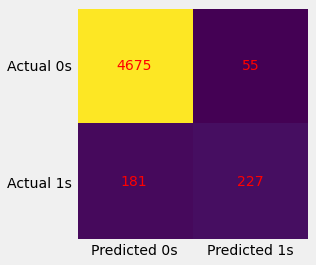

In [23]:
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred)

In [52]:
param_grid = {'n_estimators': [10,20,50,100,200], 'max_features': ['auto', 'sqrt', 'log2', 0.5],\
              'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15]}
gs = GridSearchCV(estimator=model, param_grid = param_grid, scoring = 'recall', n_jobs=-1)
gs.fit(X_train, y_train)
print('Best model: ', gs.best_estimator_)
y_pred = gs.best_estimator_.predict(X_test)
print('Accuracy =',gs.best_estimator_.score(X_test, y_test))
print('Recall =',recall_score(y_test, y_pred))

Best model:  RandomForestClassifier(max_depth=15, max_features=0.5, n_estimators=50,
                       random_state=0)
Accuracy = 0.891566265060241
Recall = 0.5734265734265734


[[TN, FP], [FN, TP]] =
 [[806  47]
 [ 61  82]]


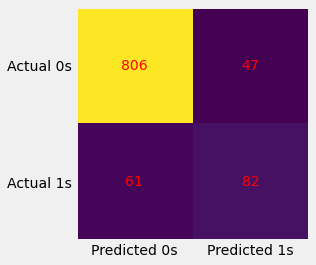

In [51]:
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred)

In [55]:
#scoring = 'roc_auc'
param_grid = {'n_estimators': [10,20,50,100,200], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15],\
              'max_features': ['auto', 'sqrt', 'log2', 0.5]}
gs = GridSearchCV(estimator=model, param_grid = param_grid, scoring = 'roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)
print('Best model: ', gs.best_estimator_)
y_pred = gs.best_estimator_.predict(X_test)
print('Accuracy =',gs.best_estimator_.score(X_test, y_test))
print('Recall =',recall_score(y_test, y_pred))

Best model:  RandomForestClassifier(criterion='entropy', max_depth=10, max_features=0.5,
                       n_estimators=50, random_state=0)
Accuracy = 0.893574297188755
Recall = 0.5524475524475524


#### ROC-AUC

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

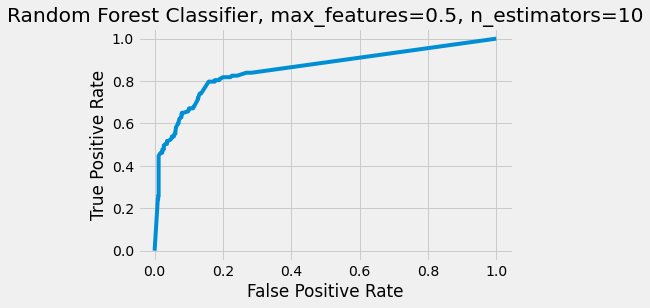

In [47]:
prob_y = gs.best_estimator_.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, prob_y, pos_label=1, drop_intermediate=False)
plt.plot(fpr, tpr, linestyle='-', label='Random Forest')
plt.title('Random Forest Classifier: max_features=0.5, n_estimators=10')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend() # show the legend
plt.show()

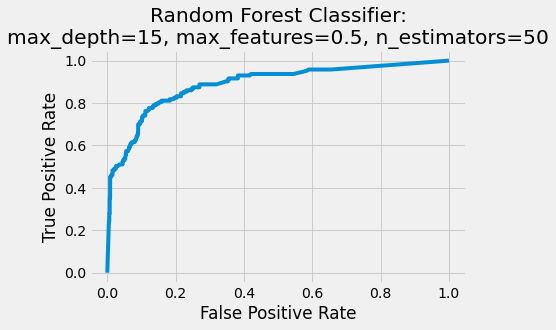

In [54]:
prob_y = gs.best_estimator_.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, prob_y, pos_label=1, drop_intermediate=False)
plt.plot(fpr, tpr, linestyle='-', label='Random Forest')
plt.title('Random Forest Classifier:\nmax_depth=15, max_features=0.5, n_estimators=50')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend() # show the legend
plt.show()

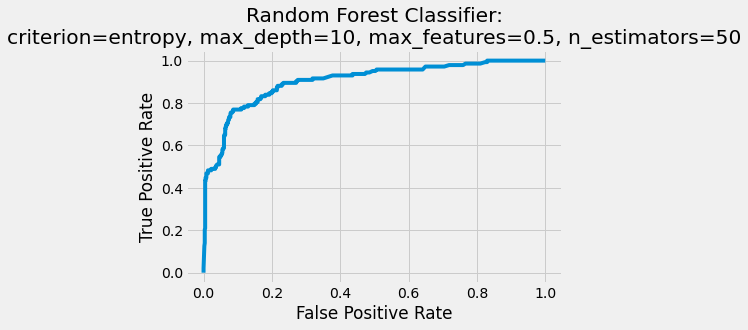

In [57]:
prob_y = gs.best_estimator_.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, prob_y, pos_label=1, drop_intermediate=False)
plt.plot(fpr, tpr, linestyle='-', label='Random Forest')
plt.title('Random Forest Classifier:\ncriterion=entropy, max_depth=10, max_features=0.5, n_estimators=50')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend() # show the legend
plt.show()

### Precision-Recall Curve

In [59]:
from sklearn.metrics import precision_recall_curve, auc
import seaborn as sns

C:\Programs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Programs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AUC: 0.708


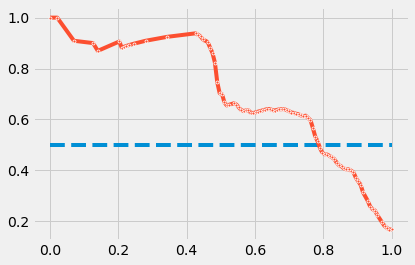

In [60]:
precision, recall, thresholds = precision_recall_curve(y_test, prob_y)
pr_auc_score = auc(recall, precision)
sns.lineplot([0, 1], [0.5, 0.5], linestyle='--')
plt = sns.lineplot(recall, precision, marker='.')
print('AUC: %.3f' % pr_auc_score)

## Quality metrics

| Transactions | Date | Accuracy No Split   | Accuracy 30% Test | Accuracy CV 10 | n_estimators | criterion | max_depth | max_features |
|---:|:-------------|:-----------|:------|:------|:------|:------|:------|:------|
| 1 | 2016-10-22 | 0.9790794979079498 | 0.9128919860627178 | 0.9208001346650206 | 100 | gini | None | auto |
| 2 | O  | O | 0.9024390243902439 | O     | 200 | gini | 25 | 0.5 |